# JOSS example: NLMOD workflow

---

This example is create for the paper _"xxxxxx"_ that was published in the Journal of Open Source Software (JOSS).



### Import Python packages

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import nlmod
import flopy as fp
import xarray as xr
from pandas import Timestamp, date_range

nlmod.util.get_color_logger("INFO")

/home/vonkm/repos/nlmod/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<RootLogger root (INFO)>

### Define spatial properties, name and directories

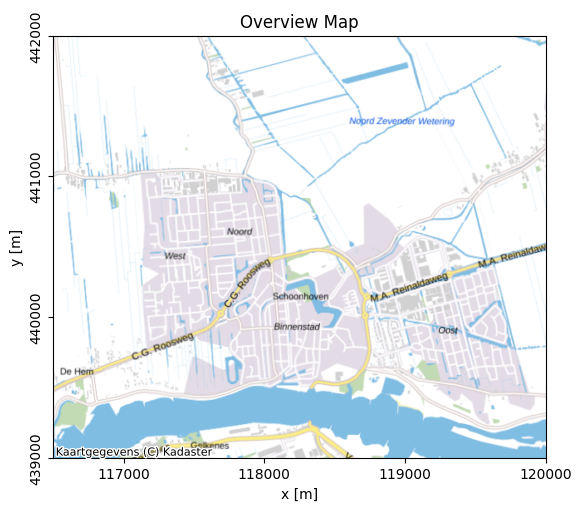

In [2]:
crs = "EPSG:28992"
extent = [116_500.0, 120_000.0, 439_000.0, 442_000.0]

# set name and directories
model_ws = model_name = "schoonhoven" # model workspace and modelname
figdir, cachedir = nlmod.util.get_model_dirs(model_ws) # figure and cache directories

# plot map
f, ax = nlmod.plot.get_map(extent, crs=crs, figsize=(7.0, 5.0), background=True, alpha=1.0, base=1000.0, fmt_base=1.0)
ax.set(xlabel="x [m]", ylabel="y [m]", title="Overview Map")
f.savefig(figdir + f"/{model_name}_map.png", dpi=300, bbox_inches="tight")

### Download relevant data

INFO:nlmod.cache.wrapper:using cached data -> regis.nc
INFO:nlmod.cache.decorator:using cached data -> bgt.pklz
INFO:nlmod.cache.wrapper:using cached data -> ahn.nc


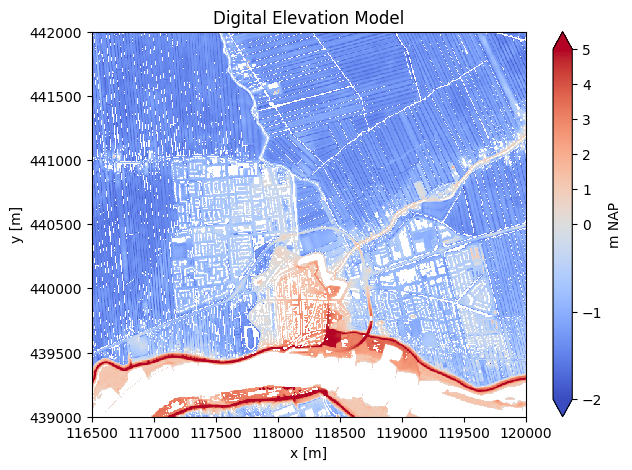

In [3]:
# download a geohydrological layer model (regis)
regis_ds = nlmod.read.regis.download_regis(extent, cachedir=cachedir, cachename="regis")

# download surface water levels (bgt)
bgt_gdf = nlmod.read.bgt.download_bgt(extent=extent, cachedir=cachedir, cachename="bgt")

# download DEM (ahn)
ahn = nlmod.read.ahn.download_ahn(extent=extent, cachedir=cachedir, cachename="ahn")

# plot the digital elevation model
f, ax = plt.subplots(figsize=(7.0, 5.0))
norm = mpl.colors.TwoSlopeNorm(vmin=-2.0, vmax=5.0, vcenter=0.0)
cmap = plt.get_cmap("coolwarm")
ahn.plot(ax=ax, cbar_kwargs={"label":"m NAP"}, norm=norm, cmap=cmap)
ax.set(xlabel="x [m]", ylabel="y [m]", title="Digital Elevation Model")
f.savefig(figdir+f"/{model_name}_dem.png", dpi=300, bbox_inches="tight")

### Discretize

INFO:nlmod.dims.base.to_model_ds:resample layer model data to structured modelgrid


INFO:nlmod.dims.layers.get_kh_kv:kv and kh both undefined in layer HLc
INFO:nlmod.dims.layers._fill_var:Filling 7594 values in active cells of kh by multipying kv with an anisotropy of 10
INFO:nlmod.dims.layers._fill_var:Filling 16762 values in active cells of kv by dividing kh by an anisotropy of 10
INFO:nlmod.dims.layers._fill_var:Filling 1050 values in active cells of kh with a value of 1.0 m/day
INFO:nlmod.dims.layers._fill_var:Filling 1050 values in active cells of kv with a value of 0.1 m/day


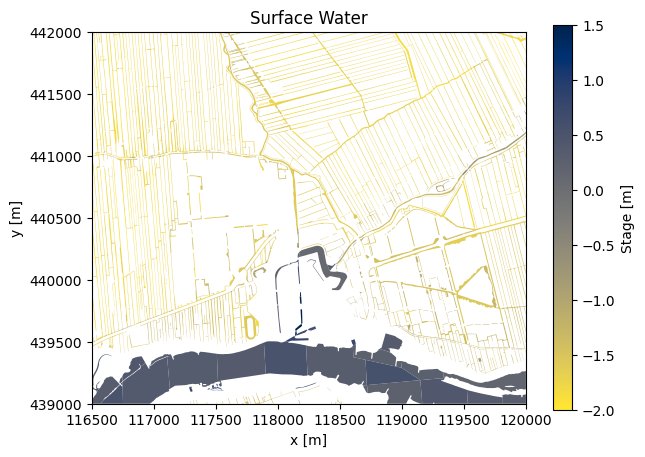

In [4]:
dx, dy = 100.0, 100.0 # cellsize

# discretise layer model (regis) to model dimensions
ds = nlmod.to_model_ds(regis_ds, model_name, model_ws, delr=dx, delc=dy)

# add DEM (ahn) to model dataset
ds.update(nlmod.read.ahn.discretize_ahn(ds, ahn))

# specify recharge
ds["recharge"] = xr.ones_like(ds["top"]) * 0.0007 # 0.7 mm/day

# add minimum digital elevation to use as surface water stage
bgt_gdf = nlmod.gwf.add_min_ahn_to_gdf(bgt_gdf, ahn, buffer=5.0, column="stage").dropna(subset="stage")
ax = bgt_gdf.plot("stage", legend=True, figsize=(7.0, 5.0), cmap="cividis_r", vmin=-2.0, vmax=1.5)
ax.set_xlim(extent[0], extent[1])
ax.set_ylim(extent[2], extent[3])
ax.set(xlabel="x [m]", ylabel="y [m]", title="Surface Water")
fig = ax.get_figure()
fig.axes[-1].set_ylabel("Stage [m]")
fig.savefig(figdir+f"/{model_name}_stage.png", dpi=300, bbox_inches="tight")

# set model time settings
tmin = Timestamp("2010-01-01")
tmax = Timestamp("2020-01-01")
freq = "14D"
t = date_range(tmin, tmax, freq=freq)
ds = nlmod.time.set_ds_time(ds, start=3652, time=t, steady_start=True)

### Build groundwater flow model

In [5]:
# build the modflow6 gwf model
gwf = nlmod.gwf.ds_to_gwf(ds)

# discretize surface water data
sfw_grid = nlmod.grid.gdf_to_grid(
    bgt_gdf, gwf, cachedir=ds.cachedir, cachename="sfw_grid.pklz"
)

# add bed resistance to calculate conductance
bed_resistance = 10.0  # days
sfw_grid["cond"] = sfw_grid.area / bed_resistance
sfw_grid.set_index("cellid", inplace=True)

# build stress period data for RIV package
drn_spd = nlmod.gwf.surface_water.build_spd(sfw_grid, "DRN", ds)

# flopy is used to construct the DRN package directly
drn = fp.mf6.ModflowGwfdrn(gwf, stress_period_data=drn_spd)

INFO:nlmod.sim.sim.sim:creating mf6 SIM


INFO:nlmod.sim.sim.tdis:creating mf6 TDIS
INFO:nlmod.sim.sim.ims:creating mf6 IMS
INFO:nlmod.gwf.gwf.gwf:creating mf6 GWF
INFO:nlmod.gwf.gwf._dis:creating mf6 DIS
INFO:nlmod.gwf.gwf.npf:creating mf6 NPF
INFO:nlmod.gwf.gwf.ic:creating mf6 IC
INFO:nlmod.gwf.gwf.ic:adding 'starting_head' data array to ds
INFO:nlmod.gwf.gwf.oc:creating mf6 OC
INFO:nlmod.gwf.gwf.rch:creating mf6 RCH
INFO:nlmod.cache.decorator:using cached data -> sfw_grid.pklz


Building stress period data DRN: 100%|██████████| 4171/4171 [00:00<00:00, 5401.41it/s]


In [6]:
# build and run model
nlmod.sim.write_and_run(gwf, ds, silent=True)

INFO:nlmod.sim.sim.write_and_run:write model dataset to cache
INFO:nlmod.sim.sim.write_and_run:write modflow files to model workspace
INFO:nlmod.sim.sim.write_and_run:run model


### Post-processing

Plotting the average head in REGIS layer PZWAz3

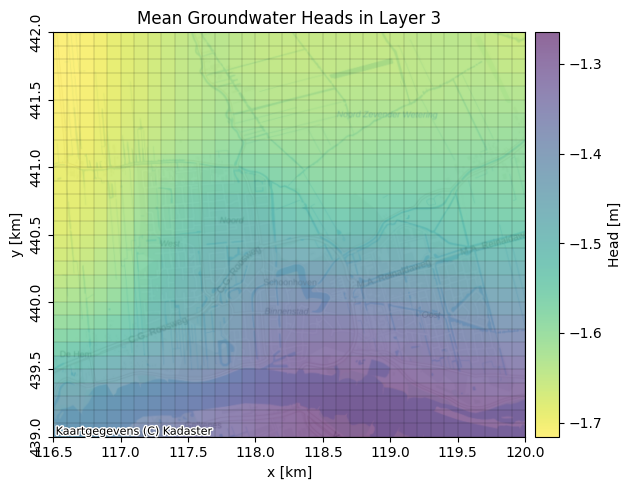

In [14]:
# load the computed heads
head = nlmod.gwf.output.get_heads_da(ds)

# plot on map
layer = 3
ax = nlmod.plot.map_array(
    head.isel(layer=layer).mean(dim="time"),
    ds,
    alpha=0.6,
    cmap=plt.get_cmap("viridis_r"),
    background=True,
    colorbar_label="Head [m]",
    xlabel="x [km]",
    ylabel="y [km]",
    figsize=(7.0,5.0),
    title=f"Mean Groundwater Heads in Layer {layer}"
)
ax.get_figure().savefig(figdir + f"/{model_name}_heads.png", dpi=300, bbox_inches="tight")

In [ ]:
# Copy figures

# from shutil import copy
# from pathlib import Path
# dest_path = Path("../../paper/figures")
# for src_path in Path(figdir).glob("*.png"):
#     copy(src_path, dest_path)